# Add +/- 1 standard deviation to the map_soln prediction plot

In [1]:
from round import lc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# https://archive.stsci.edu/hlsps/everest/v2/c102/201000000/48855/hlsp_everest_k2_llc_201048855-c102_kepler_v2.0_lc.fits medium-high frequency, looks kinda nice. 
# https://archive.stsci.edu/hlsps/everest/v2/c102/201200000/12221/hlsp_everest_k2_llc_201212221-c102_kepler_v2.0_lc.fits low frequency, looks good plotted with covariance prediction  
# https://archive.stsci.edu/hlsps/everest/v2/c102/201100000/81885/hlsp_everest_k2_llc_201181885-c102_kepler_v2.0_lc.fits high frequency, looks nice 
# https://archive.stsci.edu/hlsps/everest/v2/c01/201100000/79758/hlsp_everest_k2_llc_201179758-c01_kepler_v2.0_lc.fits real coherent oscillations with beating 
# https://archive.stsci.edu/hlsps/everest/v2/c01/201600000/11969/hlsp_everest_k2_llc_201611969-c01_kepler_v2.0_lc.fits flares
light_curve = lc.LightCurve.everest("https://archive.stsci.edu/hlsps/everest/v2/c04/210800000/94955/hlsp_everest_k2_llc_210894955-c04_kepler_v2.0_lc.fits");

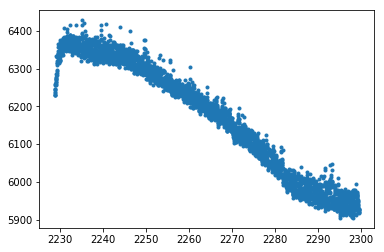

In [3]:
plt.plot(light_curve.t, light_curve.raw_flux, '.')

In [4]:
%time light_curve.compute(mcmc=True, mcmc_draws=500, tune=500, target_accept=0.9, prior_sig=3.0, with_SHOTerm=False)

optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod_interval__', 'logamp', 'logs2']
message: Optimization terminated successfully.
logp: 13874.558853599083 -> 15238.508023926113


Sampling 2 chains: 100%|██████████| 404/404 [00:09<00:00, 44.26draws/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2]
Sampling 2 chains: 100%|██████████| 1000/1000 [00:19<00:00, 33.51draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 42.9 s, sys: 2.05 s, total: 45 s
Wall time: 1min 59s


/usr/local/lib/python3.7/site-packages/pymc3/stats.py:974: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


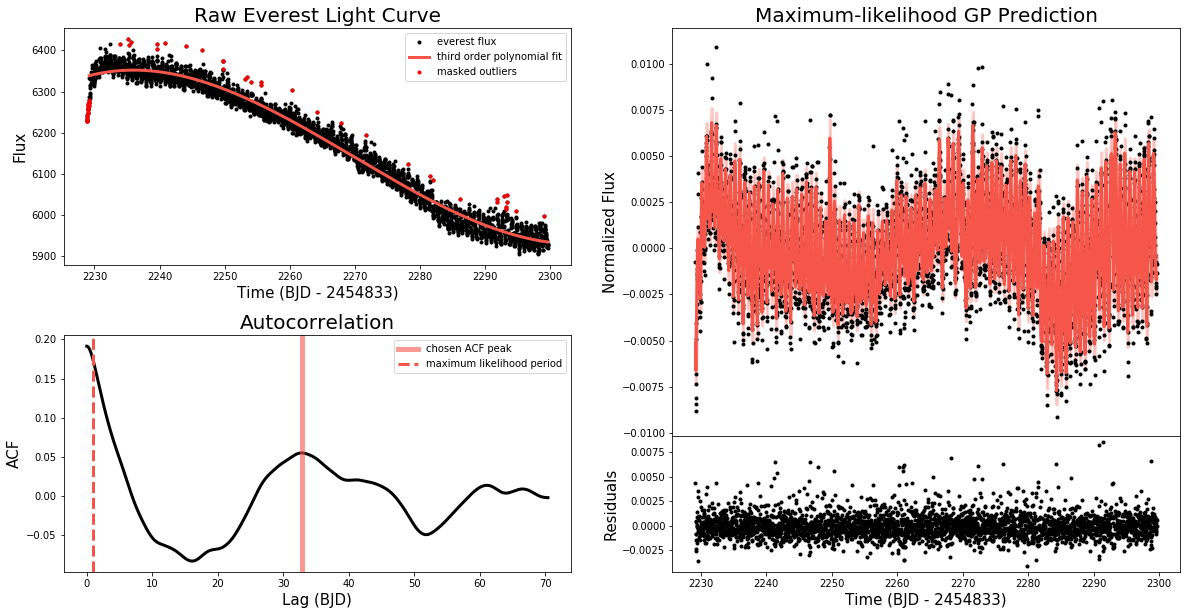

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20, 10))

really_outer = gridspec.GridSpec(1, 1, wspace=0.2, hspace=0.2)
outer = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=really_outer[0], wspace=0.2, hspace=0.2)

inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0], wspace=0.1, hspace=0.3)

# raw light curve and polynomial fit 
ax = plt.Subplot(fig, inner[0])
light_curve.plot_raw(ax, 'k.', label="everest flux")
light_curve.plot_trend(ax, linewidth=3, color="#f55649", label="third order polynomial fit")
ax.plot(light_curve.raw_t[light_curve.masked], light_curve.raw_flux[light_curve.masked], 'r.', label="masked outliers")
ax.set_title("Raw Everest Light Curve", fontsize=20)
ax.set_xlabel("Time (BJD - 2454833)", fontsize=15)
ax.set_ylabel("Flux", fontsize=15)
ax.legend()
fig.add_subplot(ax)

# autocorrelation
ax = plt.Subplot(fig, inner[1])
light_curve.plot_autocor(ax, "k", linewidth=3)
ax.axvline(light_curve.map_soln["period"], color="#f55649", label="maximum likelihood period", linewidth=3, linestyle="--")
ax.set_title("Autocorrelation", fontsize=20)
ax.set_xlabel("Lag (BJD)", fontsize=15)
ax.set_ylabel("ACF", fontsize=15)
ax.legend()
fig.add_subplot(ax)

inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[1], wspace=0.1, hspace=0, height_ratios=[3, 1])

# GP prediction
ax = plt.Subplot(fig, inner[0])
light_curve.plot(ax, 'k.', label="normalized everest flux")
light_curve.plot_map_soln(ax, t=np.linspace(light_curve.t[0], light_curve.t[-1], 1000), linewidth=3, color="#f55649", label="GP prediction")
ax.set_title("Maximum-likelihood GP Prediction", fontsize=20)
ax.set_ylabel("Normalized Flux", fontsize=15)
fig.add_subplot(ax)

# residuals
ax = plt.Subplot(fig, inner[1])
#ax.plot(light_curve.t, light_curve.flux - light_curve.map_soln["mu"], 'k.')
light_curve.plot_residuals(ax, 'k.')
ax.set_ylabel("Residuals", fontsize=15)
ax.set_xlabel("Time (BJD - 2454833)", fontsize=15)
fig.add_subplot(ax)

fig.savefig("/Users/tgordon/Desktop/diagnostic_plot.png", dpi=200)

/usr/local/lib/python3.7/site-packages/pymc3/stats.py:974: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


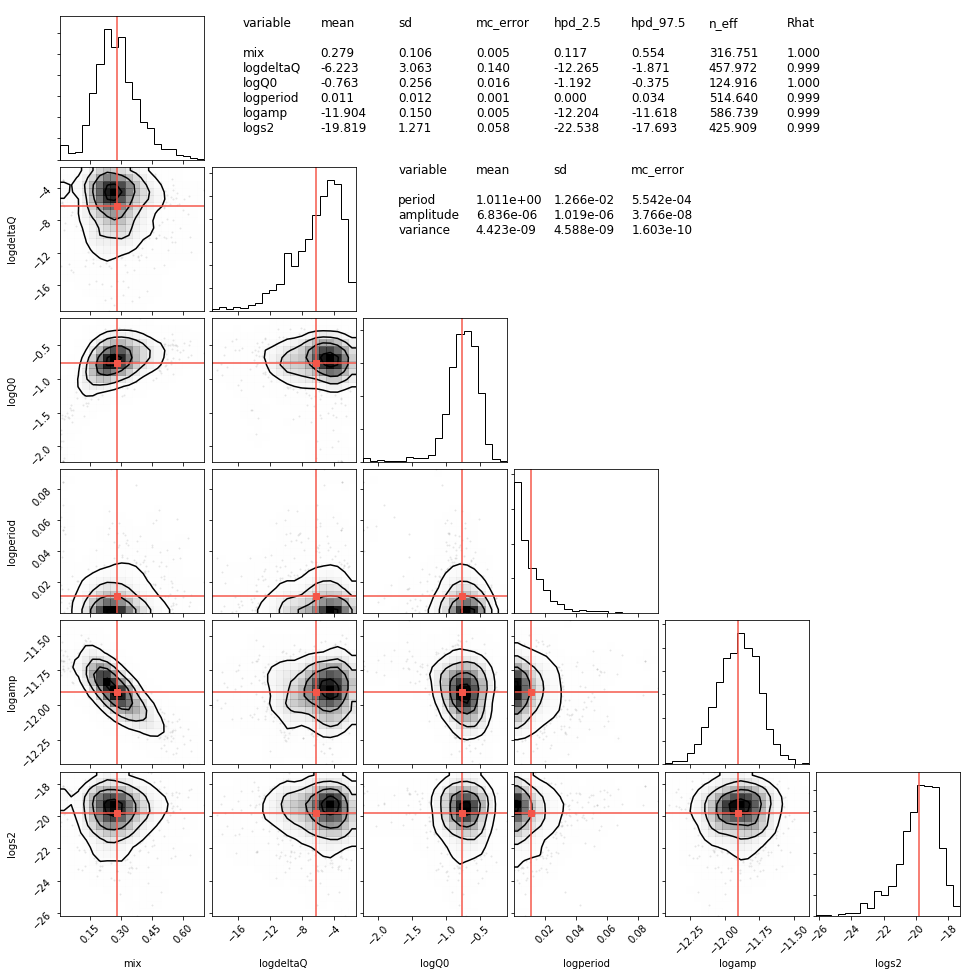

In [6]:
light_curve.plot_corner(smooth=True, truths=light_curve.mcmc_summary["mean"].values, truth_color="#f55649");
plt.savefig("/Users/tgordon/Desktop/corner_plot.pdf")